In [3]:
%load_ext autoreload
%autoreload 2
#Basic package
import math
import random
import time
import numpy as np
import pandas as pd
import xlwt
#ML
from scipy.spatial.distance import cdist
from scipy.cluster.vq import vq
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans  
from sklearn.datasets import make_blobs
from sklearn import cluster, datasets
#Plot
from matplotlib.pyplot import *
from pylab import *
import matplotlib.pyplot as plt
#functions for the framework
from util import *
#from related_SM_algorithm import *

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
#d_bar: formula(5) of paper

def distEclud(vecA, vecB):
    return np.sqrt(np.sum(np.power(vecA - vecB, 2)))


def D_bar(centroids):
    A = len(centroids)
    total_sum = 0
    for i in range(A):
        for j in range(A):
            total_sum += distEclud(centroids[i,:], centroids[j,:])**2
    return total_sum/(A*(A-1)) # pairwise not including self

#D_intra: formula(9) of paper
def D_intra(X, centroid):
    dist = []
    for i in range(len(X)):
        dist.append(distEclud(X[i,:],centroid)**2)
    return max(dist)+min(dist)


def compute_equivalent_class(record):
    """output the equivalent classes from pairwise relation 
       [[1,2],[2,3],[4,5]] --> [[1,2,3],[4,5]]"""
    equivalent_class = {}
    class_members=[]
    max_class_number = -1
    for pair in record:
        if (pair[0] in equivalent_class) and (not (pair[1] in equivalent_class)):
            equivalent_class[pair[1]] = equivalent_class[pair[0]]
        if (not(pair[0] in equivalent_class)) and (not (pair[1] in equivalent_class)):
            max_class_number+=1
            equivalent_class[pair[0]] = max_class_number
            equivalent_class[pair[1]] = max_class_number
    for c in range(max_class_number+1):
        class_members.append([index for index,val in equivalent_class.items() if val==c])
    return class_members
            
def batch_fussion(betas, class_members):
    """
    merge centers in the same equivalent class
    """
    merge_centers = None
    all_merge_indices = []
    for c, merge_indices in enumerate(class_members):
        all_merge_indices += merge_indices
        if isinstance(merge_centers,np.ndarray):
            merge_centers = np.vstack((merge_centers,np.mean(betas[merge_indices],axis=0)))
        else:
            merge_centers = np.mean(betas[merge_indices],axis=0)
    betas = np.delete(betas, all_merge_indices, axis=0)
    betas = np.vstack((betas, merge_centers))
    return betas

def Ds_kmeans(X, k, seed=1, batch_merge=False):
    #kmeans
    kmeans = KMeans(n_clusters=k, init='random',random_state=seed, n_init=1, algorithm='full').fit(X)
    labels = kmeans.labels_
    betas = kmeans.cluster_centers_
    split_state = True
    merge_state = True
    k_observe = []
    #----------------split------------------------
    while split_state:
        split_state = False
        d_bar = D_bar(betas)
        d_list = []
        d_inx = [] #store split index
        for index in range(len(betas)):
            d_intra = D_intra(X[labels == index],betas[index,:])
            #print (d_intra, d_bar/20)
            if d_intra > (d_bar/20):
                split_state =True
                d_list.append(d_intra)
                d_inx.append(index)
        betas = np.delete(betas, d_inx, axis=0) #删除此centroids
        for index in d_inx:
            fis_kms=KMeans(n_clusters=2,init='random',algorithm='full',random_state=0,n_init=1).fit(X[labels == index])
            fis_betas = fis_kms.cluster_centers_      
            betas=np.vstack((betas,fis_betas)) 
        #print (len(betas))
        # update labels 
        labels = compute_Voronoi(X, betas)
    k_observe.append(len(betas))

    #----------------merge------------------------
    next_k = 0
    iter1=0
    record = []
    while merge_state and len(betas)>2:
        merge_state = False
        d_bar = D_bar(betas)
        min_d = inf
        for i in range(len(betas)-1):
            for j in range(i+1,len(betas)):
                d_inter = distEclud(betas[i,:], betas[j,:])**2
                if d_inter < d_bar/40:
                    merge_state = True
                    if batch_merge:
                        record.append([i,j])
                    else:
                        if min_d > d_inter:
                            min_d = d_inter
                            record = [i,j] 
                             
        if merge_state:
            if batch_merge:
                class_index = compute_equivalent_class(record)
                betas = batch_fussion(betas, class_index)
            else:
                betas = fussion(betas, record)
            #fussion_centroid = (betas[record[0]] + betas[record[1]])/2
            #betas = np.delete(betas, record, axis=0)
            #betas = np.vstack((betas, fussion_centroid)) 
            iter1 +=1
    #print (len(betas))
    k_observe.append(len(betas))
       
    kms=KMeans(n_clusters=len(betas), init=betas, n_init=1, algorithm='full').fit(X)   
    store_C = [kms.cluster_centers_] 
    sse = [kms.inertia_]
            
    return store_C,sse,k_observe


In [30]:
def expriment_ds(data, trials, data_gt=None, init_method='random', maxIter=30):
    if data_gt==None:
        data_gt = data
    ####raw_data####
    X = pd.read_csv('./Raw_data/all/'+data, header=None, dtype=np.float64).values 
    ####ground truth####
    gt = pd.read_csv('./Groundtruth/all/'+data_gt, dtype=np.float64).values
    ##################
    ####setting####
    ##################
    k = len(gt)
    SSE_list = []
    CI_list = []
    Iters = []
    num_k = []
    Success_rate = 0 
    ##################
    ####Groud truth SSE
    ##################
    gt_model = KMeans(n_clusters=k, init=gt, random_state = 0, n_init=1, algorithm='full').fit(X)
    gt_sse = gt_model.inertia_
    ##################          
    #Main Loop
    ################## 
    start_time=time.time()
    next_seed = 0
    for i in range(trials):
        store_C,SSE,_ = Ds_kmeans(X, k, seed=i)
           
        ##################          
        #Centroid Index
        ################## 
        CI = Centroid_Index_diff(gt,store_C[-1])
        CI_list.append(CI)
        SSE_list.append(SSE[-1])
        if CI == 0:
            Success_rate+=1 
        num_k.append(len(store_C[-1]))

    Success_rate = Success_rate/trials * 100
    AMR = np.mean(CI_list)/k
    SSE_ratio = np.array(SSE_list)/gt_sse
    SSE_ratio_mean = np.mean(SSE_ratio)
    SSE_ratio_std = np.std(SSE_ratio)

    elapse_time = time.time()-start_time
    
    return (Success_rate, AMR, SSE_ratio_mean, SSE_ratio_std,np.mean(num_k), elapse_time)

In [25]:
experiment_record = {}
datasets = ['a1.csv', 'a2.csv', 'a3.csv',
           's1.csv', 's2.csv', 's3.csv','s4.csv',
           'unbalance.csv','dim032.csv','birch1.csv']

for index, data in enumerate(datasets):
    print (data)

    Success_rate, AMR, SSE_ratio_mean, SSE_ratio_std, num_k, elapse_time=expriment_ds(data, trials=100, data_gt=None)
    experiment_record[index*1]= {'dataset': data,
                                       'success_rate': Success_rate,
                                       'AMR': AMR,
                                       'SSE_ratio_mean': SSE_ratio_mean,
                                       'SSE_ratio_std': SSE_ratio_std,
                                       'Averk':num_k,
                                       'Time': elapse_time}

    
pd.DataFrame.from_dict(experiment_record, orient='index')

a1.csv
a2.csv
a3.csv
s1.csv
s2.csv
s3.csv
s4.csv
unbalance.csv
dim032.csv
birch1.csv


,dataset,success_rate,AMR,SSE_ratio_mean,SSE_ratio_std,Time
0,a1.csv,66.0,0.02450,1.124397,0.201504,24.549621
1,a2.csv,5.0,0.07000,1.330410,0.188380,44.566832
2,a3.csv,0.0,0.13520,1.676790,0.195507,75.150053
3,s1.csv,100.0,0.00000,0.968905,0.028810,111.296583
4,s2.csv,100.0,0.00000,0.716232,0.042807,218.910381
5,s3.csv,100.0,0.00000,0.460048,0.031981,391.457096
6,s4.csv,100.0,0.00000,0.385507,0.022324,418.322822
7,unbalance.csv,99.0,0.00125,1.083455,0.836112,53.883459
8,dim032.csv,100.0,0.00000,1.000007,0.000017,568.885821
9,birch1.csv,0.0,0.07630,1.243571,0.057656,308.817133


In [26]:
#save dataframe
pd.DataFrame.from_dict(experiment_record, orient='index').to_csv('Dissimilar_v2.csv')

In [32]:
experiment_record = {}
datasets = ['a1.csv', 'a2.csv', 'a3.csv',
           's1.csv', 's2.csv', 's3.csv','s4.csv',
           'unbalance.csv','dim032.csv','birch1.csv']

for index, data in enumerate(datasets):
    print (data)

    Success_rate, AMR, SSE_ratio_mean, SSE_ratio_std, num_k, elapse_time=expriment_ds(data, trials=100, data_gt=None)
    experiment_record[index*1]= {'dataset': data,
                                       'success_rate': Success_rate,
                                       'AMR': AMR,
                                       'SSE_ratio_mean': SSE_ratio_mean,
                                       'SSE_ratio_std': SSE_ratio_std,
                                       'Averk':num_k,
                                       'Time': elapse_time}

    
pd.DataFrame.from_dict(experiment_record, orient='index')

a1.csv
a2.csv
a3.csv
s1.csv
s2.csv
s3.csv
s4.csv
unbalance.csv
dim032.csv
birch1.csv


,dataset,success_rate,AMR,SSE_ratio_mean,SSE_ratio_std,Averk,Time
0,a1.csv,66.0,0.02450,1.124397,0.201504,19.51,23.435450
1,a2.csv,5.0,0.07000,1.330410,0.188380,32.55,41.938891
2,a3.csv,0.0,0.13520,1.676790,0.195507,43.24,70.711169
3,s1.csv,100.0,0.00000,0.968905,0.028810,16.37,103.517715
4,s2.csv,100.0,0.00000,0.716232,0.042807,27.25,203.178253
5,s3.csv,100.0,0.00000,0.460048,0.031981,42.59,336.554462
6,s4.csv,100.0,0.00000,0.385507,0.022324,47.05,328.729231
7,unbalance.csv,99.0,0.00125,1.083455,0.836112,8.01,43.474081
8,dim032.csv,100.0,0.00000,1.000007,0.000017,16.00,3101.773020
9,birch1.csv,0.0,0.07630,1.243571,0.057656,92.37,422.018004


In [33]:
#save dataframe
pd.DataFrame.from_dict(experiment_record, orient='index').to_csv('Dissimilar_v2.csv')

In [5]:
##################
data = 'a1.csv'
##################

(3000, 2)
(20, 2) <class 'numpy.ndarray'>


Text(0.5, 1.0, 'a1')

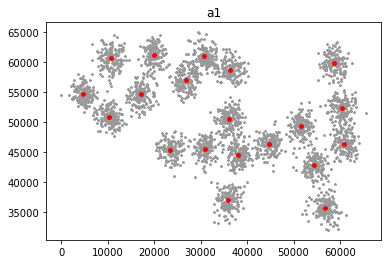

In [6]:
dataMat = pd.read_csv('./Raw_data/all/'+data, header=None, dtype=np.float64).values
print(dataMat.shape)
plt.scatter(dataMat[:, 0],dataMat[:, 1], s=5, c='0.6', marker='*')

gt = pd.read_csv('./Groundtruth/all/'+data, dtype=np.float64).values
print(gt.shape,type(gt))
#plot(gt[:, 0],gt[:, 1], 'k*',markerfacecolor=(0.5, 0.5, 0.5, 0.1), markersize=4)
plt.scatter(gt[:, 0],gt[:, 1], s=15, c='r', marker='o')
plt.title(data.strip(".csv"))

In [10]:
X=dataMat
store_C,sse,k_observe = Ds_kmeans(X, 15, seed=100, batch_merge=True)
print(len(store_C[-1]))

14


<Figure size 432x288 with 0 Axes>

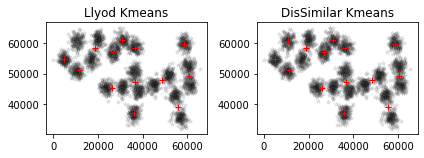

In [11]:
#--------------------------------------------------------------------------------
#------------------------------------Figure--------------------------------------
#--------------------------------------------------------------------------------
figure()
fig = plt.figure()
#Fisrt plot
plt.subplot(121)
ax = plt.subplot(221)
ax.set_title('Llyod Kmeans')
plot(dataMat[:, 0], dataMat[:, 1], 'k*',markerfacecolor=(0.5, 0.5, 0.5, 0.1), markersize=4)
plot(store_C[0][:, 0],store_C[0][:, 1], 'r+')
'''
i = 0
for a,b in zip(store_C[0][:, 0],store_C[0][:, 1]):
    i += 1
    plt.text(a+2, b+2, '%.0f'% i, color = "G", ha='center', va= 'bottom',fontsize=9)
'''
#Second plot
plt.subplot(122)
ax = plt.subplot(222)
ax.set_title('DisSimilar Kmeans')
plot(dataMat[:, 0], dataMat[:, 1], 'k*',markerfacecolor=(0.5, 0.5, 0.5, 0.1), markersize=4)
plot(store_C[-1][:, 0],store_C[-1][:, 1], 'r+')
'''
i = 0
for a,b in zip(store_C[-1][:, 0],store_C[-1][:, 1]):
    i += 1
    plt.text(a+2, b+2, '%.0f'% i, color = "G", ha='center', va= 'bottom',fontsize=9)
'''
#adjust entire empty space
fig.tight_layout()